Pairwise tests (cartesian product):



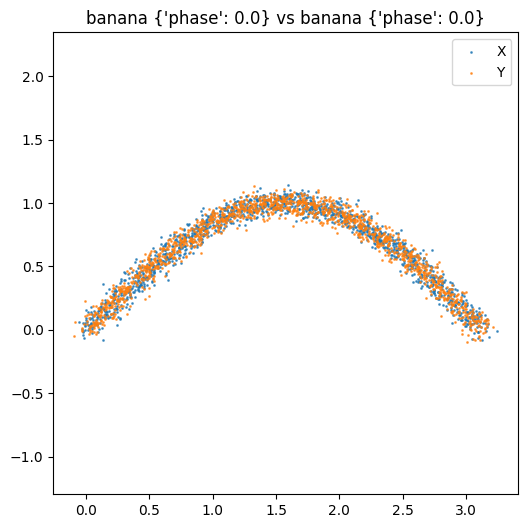

(banana, {'phase': 0.0}) vs (banana, {'phase': 0.0})
   SlicedWasserstein-PCA:   0.013061922150881302 (time: 0.00s)
   SlicedWasserstein-Diff-k:  0.000302393649629432 (time: 0.40s)
   SlicedWasserstein-Diff-More:  0.0031218688184137386 (time: 0.43s)
   Gromov-Wasserstein:      0.023022287658382417 (time: 3.66s)
   Standard OT:             0.14555492876944773 (time: 0.23s)
   Procrustes OT:           34.686855011956226 (time: 7.47s)
   StandardSlicedWasserstein:      0.00996831484763182 (time: 0.08s)



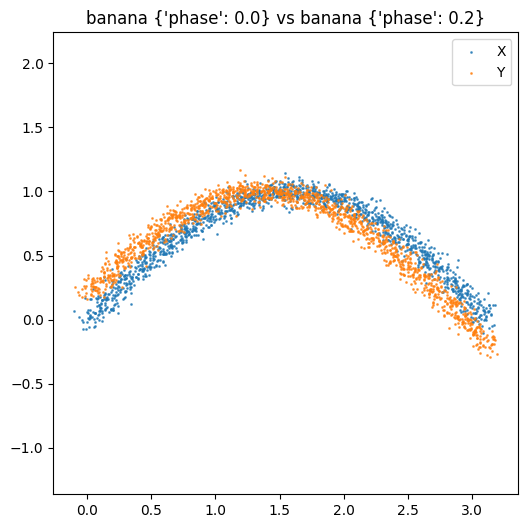

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\lp\__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


(banana, {'phase': 0.0}) vs (banana, {'phase': 0.2})
   SlicedWasserstein-PCA:   0.05606956640615457 (time: 0.00s)
   SlicedWasserstein-Diff-k:  0.0035416004443290104 (time: 0.38s)
   SlicedWasserstein-Diff-More:  0.003581707352489894 (time: 0.37s)
   Gromov-Wasserstein:      0.06074510177684319 (time: 3.71s)
   Standard OT:             0.36152719595911376 (time: 0.25s)
   Procrustes OT:           34.978996355444416 (time: 6.08s)
   StandardSlicedWasserstein:      0.08174716739029511 (time: 0.09s)



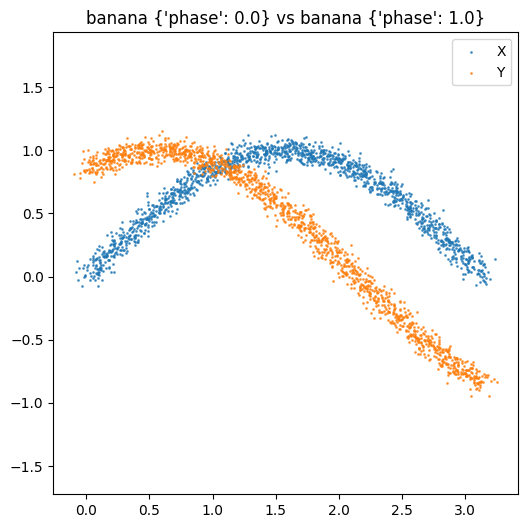

(banana, {'phase': 0.0}) vs (banana, {'phase': 1.0})
   SlicedWasserstein-PCA:   0.255221436375756 (time: 0.00s)
   SlicedWasserstein-Diff-k:  0.004061303067867929 (time: 0.36s)
   SlicedWasserstein-Diff-More:  0.003998644513006208 (time: 0.36s)
   Gromov-Wasserstein:      0.2502685791632649 (time: 3.67s)
   Standard OT:             0.7800887500183741 (time: 0.27s)
   Procrustes OT:           38.79207948280899 (time: 7.49s)
   StandardSlicedWasserstein:      0.38684522845578173 (time: 0.08s)



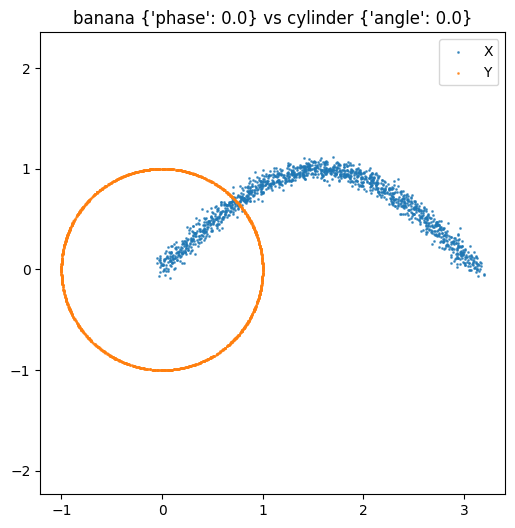

(banana, {'phase': 0.0}) vs (cylinder, {'angle': 0.0})
   SlicedWasserstein-PCA:   0.4516914056885082 (time: 0.00s)
   SlicedWasserstein-Diff-k:  0.009821384074603565 (time: 0.37s)
   SlicedWasserstein-Diff-More:  0.010208604043834876 (time: 0.38s)
   Gromov-Wasserstein:      0.7043499638845644 (time: 37.42s)
   Standard OT:             fail: XA and XB must have the same number of columns (i.e. feature dimension.) (time: 0.27s)
   Procrustes OT:           fail: the shapes of A and B differ ((1500, 3) vs (1500, 2)) (time: 7.49s)
   StandardSlicedWasserstein:      fail: shapes (1500,3) and (2,) not aligned: 3 (dim 1) != 2 (dim 0) (time: 0.08s)



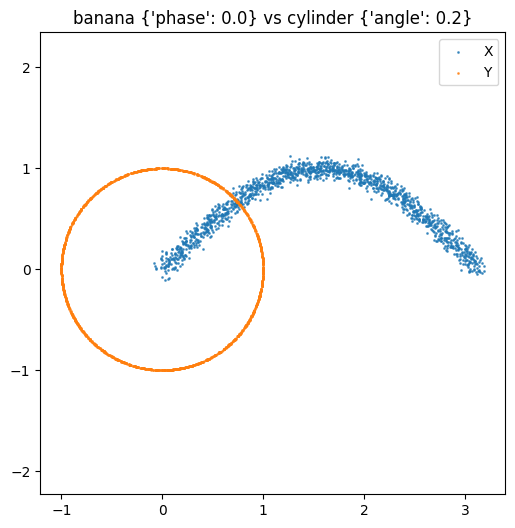

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from scipy.linalg import eigh
from sklearn.decomposition import PCA
from scipy.linalg import orthogonal_procrustes
from scipy.sparse.linalg import eigsh
from sklearn import datasets
import itertools
import matplotlib.pyplot as plt
import time

try:
    import ot  # POT: Python Optimal Transport
    has_pot = True
except ImportError:
    print("python-ot (POT) not found, Gromov-Wasserstein/OT comparison disabled")
    has_pot = False

######################
# Embedding Functions #
######################

def pca_embedding(X, k=None):
    Xc = X - X.mean(axis=0)
    pca = PCA(n_components=k if k else X.shape[1])
    pca.fit(Xc)
    return pca.transform(Xc)  # returns n x k array, like diffusion_embedding

# think more about t and symmetric normalization
def diffusion_embedding(X, k=5, epsilon=None, t=1):
    Xc = X - X.mean(axis=0)
    n = Xc.shape[0]
    D_sq = cdist(Xc, Xc, 'sqeuclidean')
    if epsilon is None:
        epsilon = np.median(D_sq)
    K = np.exp(-D_sq / epsilon)
    d = np.sum(K, axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(d))
    P_tilde = D_inv_sqrt @ K @ D_inv_sqrt

    # --- Choose eigensolver automatically ---
    # Full eigendecomposition if k >= n-1
    if k >= n - 1:
        vals, vecs = eigh(P_tilde)
        order = np.argsort(vals)[::-1]
        vals = vals[order]
        vecs = vecs[:, order]
        # Remove the trivial eigenvector (usually the top one)
        lambdas = vals[1:k+1]
        phis = vecs[:, 1:k+1]
    else:
        # Partial: only top k+1
        vals, vecs = eigsh(P_tilde, k=k+1, which='LM')
        order = np.argsort(vals)[::-1]
        vals = vals[order]
        vecs = vecs[:, order]
        lambdas = vals[1:k+1]
        phis = vecs[:, 1:k+1]

    embedding_matrix = phis * (lambdas ** t)
    return embedding_matrix


###################################
# Sliced Wasserstein Assignment   #
###################################

def get_sorted_columns(A):
    # A: n x k array
    # Returns: list of length k, each is sorted 1D array of size n
    return [np.sort(A[:, i]) for i in range(A.shape[1])]

# write more general 1D Wasserstein distance
def compute_1d_wasserstein_sorted(u_sorted, v_sorted):
    # Both should be pre-sorted arrays
    return np.mean((u_sorted - v_sorted)**2) # square is built in

def assignment_sliced_wasserstein(X, Y, AX, BY):
    k = AX.shape[1]
    # Precompute and cache sorted columns
    AX_sorted = get_sorted_columns(AX)
    BY_sorted = get_sorted_columns(BY)
    C = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            d_pos = compute_1d_wasserstein_sorted(AX_sorted[i], BY_sorted[j])
            d_neg = compute_1d_wasserstein_sorted(AX_sorted[i], -BY_sorted[j])
            C[i, j] = min(d_pos, d_neg) # square has been done already
    row_ind, col_ind = linear_sum_assignment(C)
    total_cost = C[row_ind, col_ind].sum()
    return np.sqrt(total_cost) # to hopefully be a pseudometric - regardless, matching units

##############################
# Baselines: GW and OT and ...#
##############################

def gromov_wasserstein(X, Y):
    if not has_pot:
        return np.nan
    C1 = cdist(X, X)  # pairwise distance matrix for X
    C2 = cdist(Y, Y)  # pairwise distance matrix for Y
    # we assume uniform distributions for both sets
    p = np.ones(len(X)) / len(X)
    q = np.ones(len(Y)) / len(Y)
    # GW returns the cost directly (not the coupling)
    gw_cost = ot.gromov.gromov_wasserstein2(C1, C2, p, q, 'square_loss')
    return np.sqrt(gw_cost) # we need to square root because assignment_sliced_wasserstein returns sqrt of cost and we want to be consistent


def standard_ot(X, Y):
    if not has_pot:
        return np.nan
    # same deal as GW
    C = cdist(X, Y)
    p = np.ones(len(X)) / len(X)
    q = np.ones(len(Y)) / len(Y)
    T = ot.emd(p, q, C, numItermax=10000000)
    ot_cost = (C * T).sum()
    return np.sqrt(ot_cost) # we need to square root because assignment_sliced_wasserstein returns sqrt of cost and we want to be consistent

def orthogonal_procrustes_matching(X, Y, max_iter=100, tol=1e-6, verbose=False):
    Xc = X - X.mean(axis=0)
    Yc = Y - Y.mean(axis=0)
    n, d = Xc.shape

    # Start with identity permutation
    pi = np.arange(n)
    cost_prev = np.inf
    for it in range(max_iter):
        # Step 1: Solve Procrustes for current matching
        R, scale = orthogonal_procrustes(Yc[pi], Xc)
        Yc_aligned = scale * Yc @ R

        # Step 2: Match aligned Y to X
        C = cdist(Xc, Yc_aligned, 'sqeuclidean')
        row_ind, col_ind = linear_sum_assignment(C)
        cost = C[row_ind, col_ind].sum()
        if verbose:
            print(f"Iter {it}: cost = {cost:.8f}")
        if np.abs(cost - cost_prev) < tol:
            break
        cost_prev = cost
        pi = col_ind  # New permutation

    # Final transform using best matching
    R, scale = orthogonal_procrustes(Yc[pi], Xc)
    Yc_aligned = scale * Yc @ R
    Y_aligned = Yc_aligned + X.mean(axis=0)
    return cost, (Y_aligned, R, pi)


def procrustes_ot(X, Y):
    if not has_pot:
        return np.nan
    cost, (Y_aligned, R, pi) = orthogonal_procrustes_matching(X, Y)
    # Now you can compare X and Y_aligned, or run OT/GW/etc.
    # For vanilla OT cost:
    return standard_ot(X, Y_aligned)

def sliced_wasserstein(X, Y, n_proj=100, p=2, seed=None):
    """
    Standard Sliced Wasserstein (squared Wp, default W2):
      - Projects onto random unit vectors
      - Computes 1D Wasserstein between projections
      - Returns the mean distance across all projections (root if p=2)
    """
    rng = np.random.default_rng(seed)
    n, d = X.shape
    m = Y.shape[0]
    dists = []
    for _ in range(n_proj):
        v = rng.normal(size=d)
        v /= np.linalg.norm(v)  # unit vector

        # Project onto v
        X_proj = np.dot(X, v)
        Y_proj = np.dot(Y, v)

        # Sort and compute 1D Wasserstein-p distance
        X_proj_sorted = np.sort(X_proj)
        Y_proj_sorted = np.sort(Y_proj)
        # Need equal sizes for empirical distributions: subsample or interpolate if needed
        n_used = min(len(X_proj_sorted), len(Y_proj_sorted))
        Xs = X_proj_sorted[:n_used]
        Ys = Y_proj_sorted[:n_used]
        dist = np.mean(np.abs(Xs - Ys) ** p)
        dists.append(dist)

    return np.mean(dists)**(1/p)




########################
# Synthetic Datasets   #
########################

def generate_dataset(kind, n=100, d=2, mean=None, cov=None, angle=None, phase=None):
    if kind == 'normal':
        m = mean if mean is not None else np.zeros(d)
        c = cov if cov is not None else np.eye(d)
        X = np.random.multivariate_normal(m, c, n)
        return X
    elif kind == 'banana':
        t = np.linspace(0, np.pi, n)
        phi = phase if phase is not None else 0.0
        X = np.vstack([t, np.sin(t + phi)]).T + 0.05 * np.random.randn(n, 2)
        return X
    elif kind == 'cylinder':
        theta = np.random.uniform(0, 2*np.pi, n)
        z = np.random.uniform(-1, 1, n)
        ang = angle if angle is not None else 0.0
        X = np.vstack([np.cos(theta + ang), np.sin(theta + ang), z]).T
        return X
    elif kind == 'swissroll':
        X, _ = datasets.make_swiss_roll(n)
        return X[:, :d]
    else:
        raise ValueError('Unknown dataset kind')

def plot_pair(X, Y, title=None, savepath=None):
    plt.figure(figsize=(6,6))
    plt.scatter(X[:,0], X[:,1], s=1, label='X', alpha=0.7)
    plt.scatter(Y[:,0], Y[:,1], s=1, label='Y', alpha=0.7)
    plt.axis('equal')
    plt.legend()
    if title:
        plt.title(title)
    if savepath:
        plt.savefig(savepath)
        plt.close()
    else:
        plt.show()

##########################################################
# Dataset parameterizations to try (expand as desired)   #
##########################################################

DATASET_PARAMS = {
    'banana': [
        dict(phase=0.0), 
        dict(phase=0.2),
        dict(phase=1.0),
    ],
    'cylinder': [
        dict(angle=0.0), 
        dict(angle=0.2),
        dict(angle=np.pi/2),
    ],
    'normal': [
        dict(mean=np.zeros(2)), 
        dict(mean=np.ones(2)), 
        dict(mean=np.array([2.0, -2.0])),
        dict(mean=np.zeros(2), cov=np.diag([1, 4])),
        dict(mean=np.zeros(2), cov=2*np.eye(2)),
        dict(mean=np.zeros(2), angle=np.pi/4),  # for rotation
    ],
    'swissroll': [
        dict(),  # no params
    ]
}

########################################
# Cartesian Product of Tests Framework #
########################################

def test_framework():
    dataset_types = list(DATASET_PARAMS.keys())
    configs = []
    for dtype in dataset_types:
        for params in DATASET_PARAMS[dtype]:
            configs.append((dtype, params))

    print("Pairwise tests (cartesian product):\n")
    for (dtype1, p1), (dtype2, p2) in itertools.product(configs, configs):
        # Generate X and Y
        n = 1500  # number of samples
        X = generate_dataset(dtype1, n=n, d=2, **p1)
        Y = generate_dataset(dtype2, n=n, d=2, **p2)
        plot_pair(X, Y, title=f'{dtype1} {p1} vs {dtype2} {p2}', savepath=None)
        k = min(X.shape[1], Y.shape[1])  # be safe - take the minimum of the dimensions of the spaces

        # PCA Embedding
        t0 = time.time()
        AX = pca_embedding(X, k)
        BY = pca_embedding(Y, k)
        d_pca = assignment_sliced_wasserstein(X, Y, AX, BY)
        t1 = time.time()
        pca_time = t1 - t0

        # Diffusion Embedding
        try:
            t0 = time.time()
            AX_diff = diffusion_embedding(X, k=k)
            BY_diff = diffusion_embedding(Y, k=k)
            d_diff = assignment_sliced_wasserstein(X, Y, AX_diff, BY_diff)
            t1 = time.time()
            diff_time = t1 - t0

            t0 = time.time()
            #AX2_diff = diffusion_embedding(X, k=n-1)
            #BY2_diff = diffusion_embedding(Y, k=n-1)
            AX2_diff = diffusion_embedding(X, k=10)
            BY2_diff = diffusion_embedding(Y, k=10)
            d2_diff = assignment_sliced_wasserstein(X, Y, AX2_diff, BY2_diff)
            t1 = time.time()
            diff2_time = t1 - t0
        except Exception as e:
            d_diff = f'fail: {e}'
            d2_diff = f'fail: {e}'

        # GW and OT
        d_gw = d_ot = d_proc = None
        if has_pot:
            try:
                t0 = time.time()
                d_gw = gromov_wasserstein(X, Y)
                t1 = time.time()
                gw_time = t1 - t0
            except Exception as e:
                d_gw = f'fail: {e}'
            try:
                t0 = time.time()
                d_ot = standard_ot(X, Y)
                t1 = time.time()
                ot_time = t1 - t0
            except Exception as e:
                d_ot = f'fail: {e}'
            try: 
                t0 = time.time()
                d_proc = procrustes_ot(X, Y)
                t1 = time.time()
                procrustes_time = t1 - t0
            except Exception as e:
                d_proc = f'fail: {e}'
            try: 
                t0 = time.time()
                d_sliced = sliced_wasserstein(X, Y, n_proj=1000, p=2)
                t1 = time.time()
                sliced_time = t1 - t0
            except Exception as e:
                d_sliced = f'fail: {e}'

        print(f'({dtype1}, {p1}) vs ({dtype2}, {p2})\n'
          f'   SlicedWasserstein-PCA:   {d_pca} (time: {pca_time:.2f}s)\n'
          f'   SlicedWasserstein-Diff-k:  {d_diff} (time: {diff_time:.2f}s)\n'
          f'   SlicedWasserstein-Diff-More:  {d2_diff} (time: {diff2_time:.2f}s)\n'
          f'   Gromov-Wasserstein:      {d_gw} (time: {gw_time:.2f}s)\n'
          f'   Standard OT:             {d_ot} (time: {ot_time:.2f}s)\n'
          f'   Procrustes OT:           {d_proc} (time: {procrustes_time:.2f}s)\n'
          f'   StandardSlicedWasserstein:      {d_sliced} (time: {sliced_time:.2f}s)\n'
          )

if __name__ == '__main__':
    test_framework()